In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. Import các thư viện cần thiết**

In [ ]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


**2. Đọc file dữ liệu HPG và chia dataset theo tỉ lệ 6:3:1**

In [ ]:
# Đọc file dữ liệu
df = pd.read_csv('/content/drive/MyDrive/StockData/HPG.csv')

df = df[['Price','Low']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df1 = df
# Split the data into training, testing, and validation
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

**Xem** **lại** **dataset**

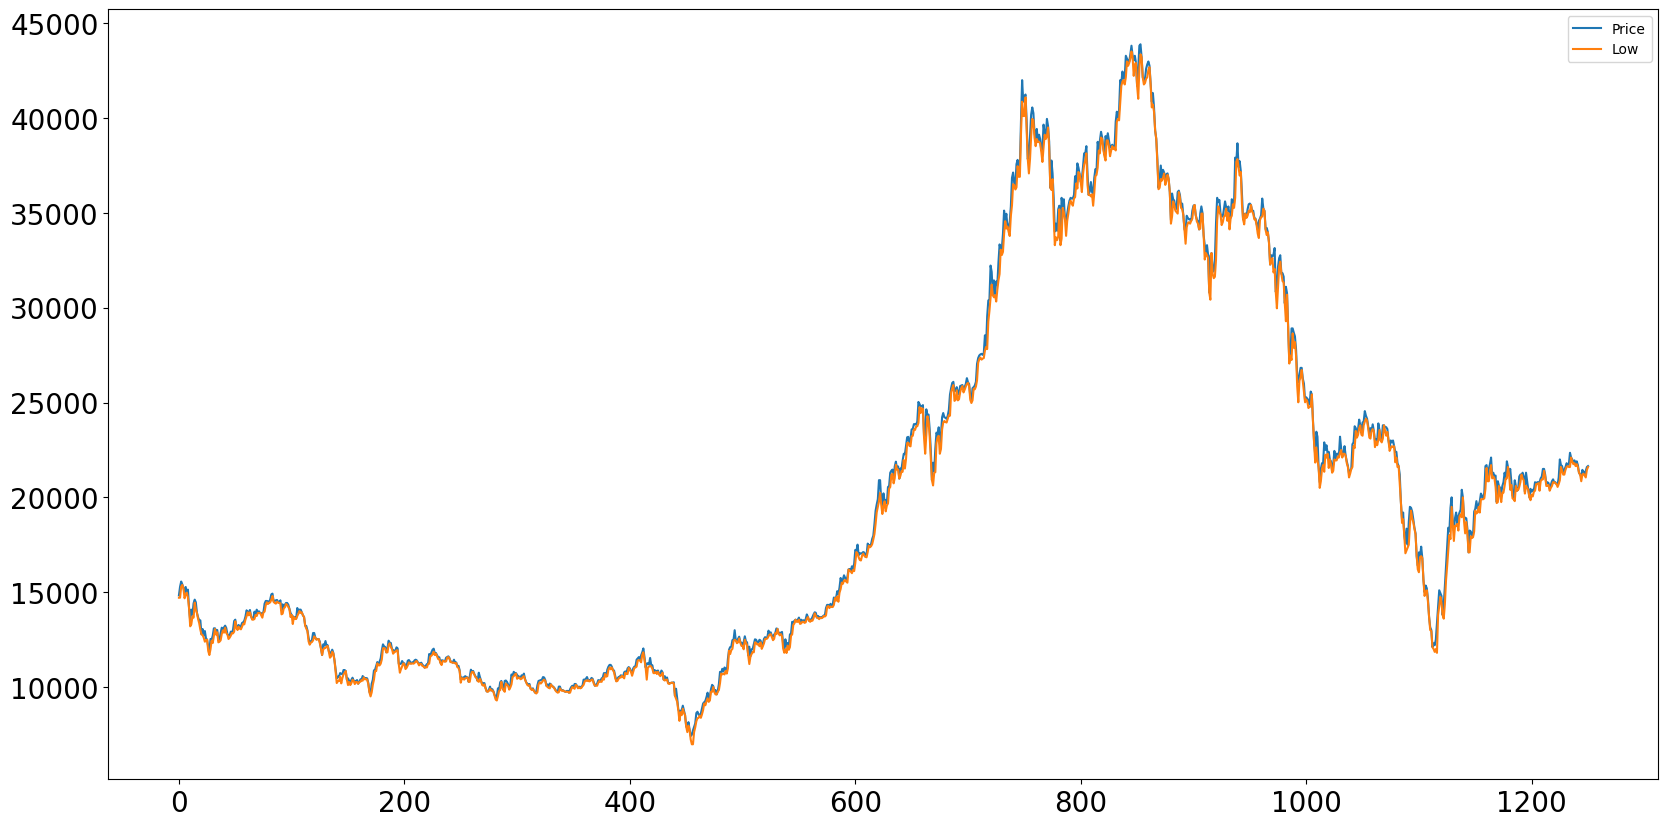

In [ ]:
df.plot(figsize=(20, 10), fontsize=20)
plt.show()

***Tìm m thích hợp***

In [ ]:

from statsmodels.tsa.stattools import adfuller
adfuller(df['Price'])

(-1.2187642601016335,
 0.6654721662261358,
 15,
 1235,
 {'1%': -3.4356560275160835,
  '5%': -2.8638831211270817,
  '10%': -2.568017509711682},
 18731.487268410645)

In [ ]:
df_diff = df1['Price'].diff().dropna()

In [ ]:
adfuller(df_diff)

(-7.395504537849762,
 7.797592879227417e-11,
 14,
 1235,
 {'1%': -3.4356560275160835,
  '5%': -2.8638831211270817,
  '10%': -2.568017509711682},
 18715.811266993263)

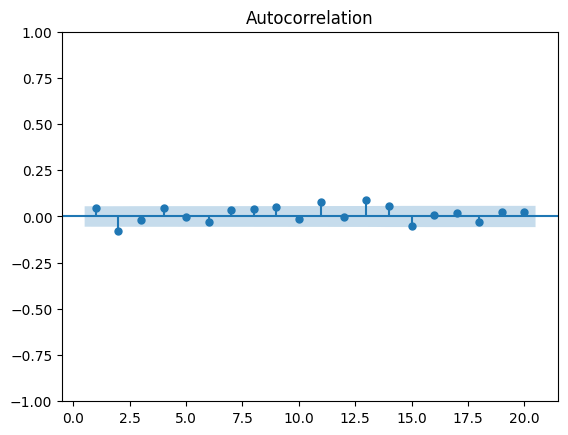

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_diff, lags = 20 , zero = False)
plt.show()

**3. Dùng auto_arima để tìm model thích hợp**

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.9 MB/s eta 0:00:00


In [ ]:
df

,Price,Low
0,14831.7,14706.0
1,15284.1,14706.0
2,15560.7,15284.1
3,15409.8,15384.7
4,15233.9,15208.7
...,...,...
1246,21350.0,21250.0
1247,21200.0,21150.0
1248,21400.0,21050.0
1249,21600.0,21450.0


In [ ]:

x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m =5)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[5]             : AIC=inf, Time=6.02 sec
 ARIMA(0,2,0)(0,0,0)[5]             : AIC=11378.713, Time=0.04 sec
 ARIMA(1,2,0)(1,0,0)[5]             : AIC=11218.594, Time=0.19 sec
 ARIMA(0,2,1)(0,0,1)[5]             : AIC=10915.598, Time=0.94 sec
 ARIMA(0,2,1)(0,0,0)[5]             : AIC=10914.162, Time=0.39 sec
 ARIMA(0,2,1)(1,0,0)[5]             : AIC=10915.633, Time=0.78 sec
 ARIMA(0,2,1)(1,0,1)[5]             : AIC=10917.500, Time=0.98 sec
 ARIMA(1,2,1)(0,0,0)[5]             : AIC=10915.460, Time=0.36 sec
 ARIMA(0,2,2)(0,0,0)[5]             : AIC=10915.334, Time=0.37 sec
 ARIMA(1,2,0)(0,0,0)[5]             : AIC=11216.778, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[5]             : AIC=inf, Time=0.51 sec
 ARIMA(0,2,1)(0,0,0)[5] intercept   : AIC=inf, Time=0.32 sec

Best model:  ARIMA(0,2,1)(0,0,0)[5]          
Total fit time: 11.056 seconds


ARIMA(order=(0, 2, 1), scoring_args={}, seasonal_order=(0, 0, 0, 5),
      suppress_warnings=True, with_intercept=False)

**Dùng SARIMAX để train model**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model1 = SARIMAX(y_train, exog = np.array(train_data['Price']), order=(0,2,1), seasonal_order=(0, 0 , 0, 5))
model_fit = model1.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**4. Quá trình test**

In [ ]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
exg = np.array(test_data['Low'])
y_pred_test = model_fit.predict(start=len(y_train), end=len(y_test)+len(y_train)-1, exog=exg)
y_pred_test

array([40111.69999978, 41095.49999977, 39354.89999975, 37841.19999974,
       37084.39999973, 37841.19999972, 39052.09999971, 39960.2999997 ,
       39884.59999969, 38976.39999968, 38522.29999967, 38900.79999965,
       38749.39999964, 38749.39999963, 38673.69999962, 38219.59999961,
       37689.7999996 , 38446.69999959, 39127.79999958, 38900.79999956,
       39052.09999955, 39506.19999954, 38446.69999953, 36327.59999952,
       36213.99999951, 36781.5999995 , 34813.89999949, 33300.29999948,
       33716.49999946, 33565.09999945, 33754.39999944, 35192.29999943,
       33300.29999942, 33640.79999941, 35267.9999994 , 35040.99999939,
       34662.49999938, 33792.19999936, 34586.89999935, 34965.29999934,
       35419.39999933, 35646.39999932, 35494.99999931, 35381.4999993 ,
       35759.89999929, 35835.59999927, 36554.59999926, 36289.69999925,
       37160.09999924, 37046.49999923, 36630.29999922, 36100.49999921,
       37046.4999992 , 37538.49999919, 37765.49999917, 38143.89999916,
      

**5. Quá trình validate**

In [ ]:
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
last_index = df.index[-1]
exg = np.array(val_data['Low'])
# y_pred_val =  model.predict(n_periods=len(y_val), exog = exog)
y_pred_val = model_fit.predict(start=len(x_train), end = len(x_train)+ len(y_val)-1, exog=exg)
y_pred_val

array([16349.99999978, 17199.99999977, 17999.99999975, 17799.99999974,
       19499.99999973, 18599.99999972, 17699.99999971, 18499.9999997 ,
       18499.99999969, 18599.99999968, 18249.99999967, 18999.99999965,
       19099.99999964, 18949.99999963, 19999.99999962, 18749.99999961,
       18099.9999996 , 18699.99999959, 18099.99999958, 17099.99999956,
       17099.99999955, 17949.99999954, 17849.99999953, 17899.99999952,
       18199.99999951, 19299.9999995 , 19149.99999949, 19199.99999948,
       19499.99999946, 19199.99999945, 19899.99999944, 19899.99999943,
       19899.99999942, 19949.99999941, 20449.9999994 , 21549.99999939,
       20849.99999938, 20849.99999936, 21349.99999935, 21699.99999934,
       20999.99999933, 21099.99999932, 20999.99999931, 20549.9999993 ,
       19699.99999929, 19749.99999927, 20599.99999926, 20149.99999925,
       19749.99999924, 20249.99999923, 20249.99999922, 20599.99999921,
       20999.9999992 , 20999.99999919, 21599.99999917, 21199.99999916,
      

**6. Quá trình tạo index predict 30 ngày tiếp theo**

In [ ]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Low'])

last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
exog = np.array(val_data['Low'])

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

low_next_30_days = ln_model.predict(x_next_30_days)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.predict(start=len(x_train), end = len(x_train)+ len(x_next_30_days)-1, exog=low_next_30_days)
# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[29373.83664942 29391.07395534 29408.31126126 29425.54856718
 29442.7858731  29460.02317902 29477.26048494 29494.49779087
 29511.73509679 29528.97240271 29546.20970863 29563.44701455
 29580.68432047 29597.92162639 29615.15893231 29632.39623823
 29649.63354416 29666.87085008 29684.108156   29701.34546192
 29718.58276784 29735.82007376 29753.05737968 29770.2946856
 29787.53199152 29804.76929745 29822.00660337 29839.24390929
 29856.48121521 29873.71852113]


***7.Đánh giá độ chính xác thuật toán***

In [ ]:
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred_test - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 465.5386030656136
Testing RMSE: 564.1593930770588
Validation MAPE: 1.5299837910379548
Testing MAPE: 1.2926107749520142
Validation MAE: 310.71428663502036
Testing MAE: 376.69946897685696


**8. Vẽ biểu đồ**

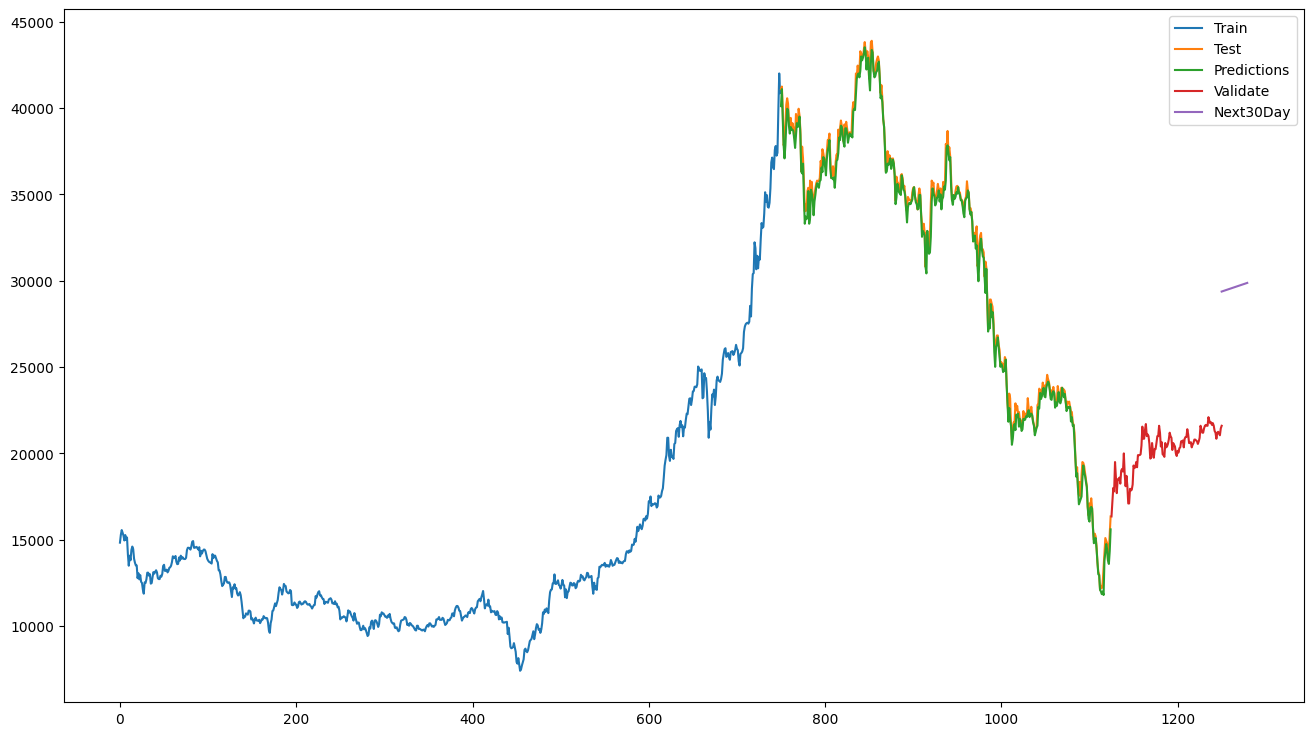

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()